Import the required libraries.

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

Read the data. The read_excel function deemed the file as a .csv file instead of an Excel file so I had to use the
read_csv function.

In [47]:
file_path = "./healthcare-dataset-stroke-data.csv.xls"
stroke_data = pd.read_csv(file_path)

The target column of our data is the "stroke" column, which is 0 if the subject hasn't had a stroke, and 1 if the patient has had a stroke. I dropped the data points that include NaN values, which dropped around 200 data points.

Finally, I dropped the id feature as it is completely useless.

In [48]:
target_column = "stroke"
stroke_data.dropna(inplace= True)
stroke_data = stroke_data.drop(columns="id")

Find the numerical and categorical columns.

In [5]:
numerical_columns = stroke_data.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = stroke_data.select_dtypes(include=["object"]).columns

Encode the categorical data using one hot encoding with the pandas library.

In [6]:
stroke_data_encoded = pd.get_dummies(stroke_data, columns= categorical_columns, drop_first= True)

print(stroke_data_encoded.head())
print(stroke_data_encoded.describe())

    age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   
5  81.0             0              0             186.21  29.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0         True         False              True                   False   
2         True         False              True                   False   
3        False         False              True                   False   
4        False         False              True                   False   
5         True         False              True                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True                    False  

Prepare the data matrix and the label vector, plus the training and testing sets. The train-test split is 80%-20%.

In [55]:
X = stroke_data_encoded.drop(columns= target_column)
y = stroke_data_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

Use the SMOTE strategy to oversample the minority class, so that the data is more homogeneous.

In [56]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Train a simple logistic regression model for now, using ALL the data points with zero DP and zero FL.

In [57]:
model = LogisticRegression(max_iter= 1000)

model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

Check the model's accuracy, recall, precision and F1 score on the test data and generate the model's confusion matrix.

Accuracy:  0.8472505091649695
Recall:  0.33962264150943394
Precision:  0.13533834586466165
F1 Score:  0.1935483870967742


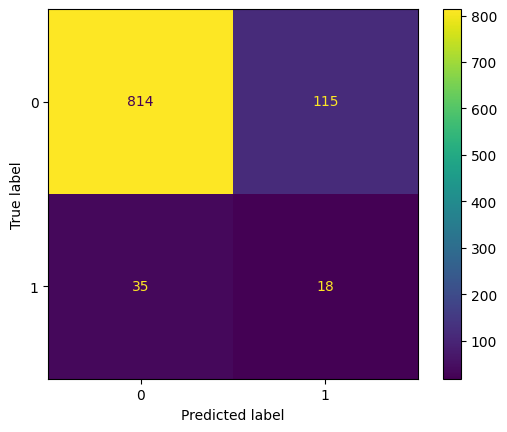

In [65]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()